In [80]:
%reload_ext autoreload
%autoreload 2

In [81]:

import math
import os
from sklearn.model_selection import train_test_split
import skimage.color as color
import numpy as np
np.set_printoptions(suppress=True)
from colors import ColorsCorpusReader
import colorsys

from transformers import pipeline
from torch_deep_neural_classifier import TorchDeepNeuralClassifier

# pipeline = pipeline('feature-extraction', model='xlnet-base-cased')
pipeline = pipeline('feature-extraction', model='gpt2')


COLORS_SRC_FILENAME = os.path.join("data", "colors", "filteredCorpus.csv")


## Class to hold target color and text

In [181]:


def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color_context(lab_cs):

    color_arr = np.asarray(lab_cs)
    max_arr   = np.argmax(color_arr, axis=0)   
    min_arr   = np.argmin(color_arr, axis=0) 
    # brightness offset
    # color_arr[           : ,0] =  0.0
    # color_arr[  max_arr[0] ,0] =  1.0
    # color_arr[  min_arr[0] ,0] = -1.0

    # no brightness offset
    color_arr[           : ,0] =  0.0
    color_arr[  max_arr[0] ,0] =  0.0
    color_arr[  min_arr[0] ,0] =  0.0



    return color_arr

def represent_color(lab,d_model):
    a    = 2.0*np.pi
    size = d_model - 1 


    c = [ np.dot( lab , [1.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,d_model,1) ]
    return np.array(c)

class ColorDataset() :



    def __init__(self,exs,d_model=128) :

        self.d_model = d_model
        # print(f"embedding dimension for a color :{self.d_model}")

        # turns a set of 3 rgb colors into 3 lab colors in context
        lab_colors      = lambda rgb_colors : represent_color_context( [ return_color(rgb_color) for rgb_color in rgb_colors] ) 

        # turns a set of 3 lab colors into 3 lab embeddings (each d_model dimensions)
        lab_embeddings  = lambda lab_colors : [ represent_color(lab_color,d_model) for lab_color in lab_colors ] 

        # retrieves hls colors and text list from examples
        all_hls_colors, self.texts  = zip(*[[ex.colors, ex.contents] for ex in exs  ] )


        # llm embeddings
        # self.llm_data               = [ np.asarray(pipeline(text)) for i,text in enumerate(self.texts) if i<10 ] 
        self.llm_data               = [ np.mean( np.asarray(pipeline(text)),axis=1).squeeze() for i,text in enumerate(self.texts) ] 

        # for i in range(0,len(self.llm_data)):
        #     print(self.llm_data[i].shape)
        # all_hls_colors, self.llm_data,self.texts  = zip( *[[hls_color,llm_d,text] for hls_color,llm_d,text in zip(all_hls_colors,self.llm_data,self.texts) if llm_d.shape[1]==1 ] )
   


        # converts hls colors to rgb colors
        self.all_rgb_colors            = [ [colorsys.hls_to_rgb(*color) for color in colors] for colors in all_hls_colors]

        # converts rgb colors to lab colors
        self.all_lab_colors            = [ lab_colors(rgb_colors) for rgb_colors in self.all_rgb_colors]

        # converts lab colors to lab embeddings
        self.all_lab_embeddings        = [ lab_embeddings(lab_colors) for lab_colors in self.all_lab_colors]

        # selects the target embedding correspnding to the target text
        self.target_embeddings           = [ lab_embeddings[2] for lab_embeddings in self.all_lab_embeddings] 

        # selects the target rgb color corresponding to the target text
        self.target_rgbs                 = [ rgb_colors[2]     for rgb_colors in self.all_rgb_colors    ] 

        self.X = np.asarray(self.llm_data)
        self.y = np.asarray(self.target_embeddings)

        print(f"number of examples     :{len(self.texts)}" )
        print(f"embedding shape        :{self.X.shape}")
        print(f"target shape           :{self.y.shape}")


  

## Create datasets with embedding and text

- dataset.target_embeddings[0]
- dataset.target_rgbs[0]
- dataset.texts[0]

In [188]:

corpus   = ColorsCorpusReader(COLORS_SRC_FILENAME,word_count=None, normalize_colors=True)
examples = list(corpus.read())

EMB_SIZE           = 128 

far_examples  =  [ex for ex in examples if ex.condition == "far" ]
split_examples = [ex for ex in examples if ex.condition == "split" ]
close_examples = [ex for ex in examples if ex.condition == "close" ]


far_train  , far_test   = train_test_split(far_examples  ,train_size=.8)
close_train, close_test = train_test_split(close_examples,train_size=.8)
split_train, split_test = train_test_split(split_examples,train_size=.8)

far_train_ds, far_test_ds     = ColorDataset(far_train,d_model=EMB_SIZE) , ColorDataset(far_test,d_model=EMB_SIZE)
close_train_ds, close_test_ds = ColorDataset(split_train,d_model=EMB_SIZE),ColorDataset(close_test,d_model=EMB_SIZE) 
split_train_ds, split_test_ds = ColorDataset(close_train,d_model=EMB_SIZE), ColorDataset(split_test,d_model=EMB_SIZE) 


number of examples     :12625
embedding shape        :(12625, 768)
target shape           :(12625, 128)
number of examples     :3157
embedding shape        :(3157, 768)
target shape           :(3157, 128)
number of examples     :12554
embedding shape        :(12554, 768)
target shape           :(12554, 128)
number of examples     :3104
embedding shape        :(3104, 768)
target shape           :(3104, 128)
number of examples     :12415
embedding shape        :(12415, 768)
target shape           :(12415, 128)
number of examples     :3139
embedding shape        :(3139, 768)
target shape           :(3139, 128)


In [189]:
from torch_autoencoder import TorchAutoencoder
import torch
from torch import nn

class TorchEncoder(TorchAutoencoder):
    # Can change loss function here
    def __init__(self,**base_kwargs):
        super().__init__(**base_kwargs)
        # self.loss = nn.NLLLoss()

    # can build a different model here
    def build_graph(self):
        return nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim*2),
            self.hidden_activation,
            nn.Linear(self.hidden_dim*2, self.hidden_dim),
            self.hidden_activation,
            nn.Linear(self.hidden_dim, self.output_dim))

    # minor variation from TorchAutoencoder base class so that 
    # the output dimention is y  
    def build_dataset(self, X, y=None) :
        # Data prep:
        X = np.array(X)
        self.input_dim = X.shape[1]

        # Dataset:
        X = self.convert_input_to_tensor(X)
        if y is None:
            dataset = torch.utils.data.TensorDataset(X)
        else:
            self.output_dim = y.shape[1]
            y = self.convert_input_to_tensor(y)
            dataset = torch.utils.data.TensorDataset(X, y)
        return dataset

    # the super super class does all the work ( as opposed to the TorchAutoencoder method)
    def fit(self, X, y):
        return super(TorchAutoencoder, self).fit(X,y)


class ModResults():
    def __init__(self,dataset):
        self.dataset = dataset
        self.mod = TorchEncoder(hidden_dim=EMB_SIZE*2 )
        self.mod.fit(dataset.X,dataset.y)

    def predict(self,dataset=None) :
        if dataset is None:
            dataset = self.dataset
        return self.mod.predict(dataset.X)
    
    def get_accuracy(self,dataset=None):
        if dataset is None:
            dataset = self.dataset            

        y_pred = self.predict(dataset)
        ys     =  dataset.all_lab_embeddings 

        index_results = []
        for i in range(len(y_pred)):
            array_corrs = [ np.corrcoef( ys[i][j], y_pred[i] )[1][0] for j in range(3)]
            max_corr    = np.argmax(array_corrs)
            index_results.append(max_corr)
        result = [1 if i == 2 else 0 for i in index_results]
        accuracy = sum(result) / len(index_results)
        return accuracy




In [190]:
far_mod   = ModResults(far_train_ds)
close_mod = ModResults(close_train_ds)
split_mod = ModResults(split_train_ds)



Stopping after epoch 155. Training loss did not improve more than tol=1e-05. Final error is 0.31399137526750565.

In [191]:
print("train accuracy")
print("  far   accuracy:" , far_mod.get_accuracy())
print("  close accuracy:" , close_mod.get_accuracy() )
print("  split accuracy:" , split_mod.get_accuracy() )
print("test accuracy")
print("  far   accuracy:" , far_mod.get_accuracy(far_test_ds) )
print("  close accuracy:" , close_mod.get_accuracy(close_test_ds) )
print("  split accuracy:" , split_mod.get_accuracy(split_test_ds) )

train accuracy
  far   accuracy: 0.8358811881188118
  close accuracy: 0.6762784769794488
  split accuracy: 0.5490132903745469
test accuracy
  far   accuracy: 0.7884067152359835
  close accuracy: 0.5202963917525774
  split accuracy: 0.5947754061803122


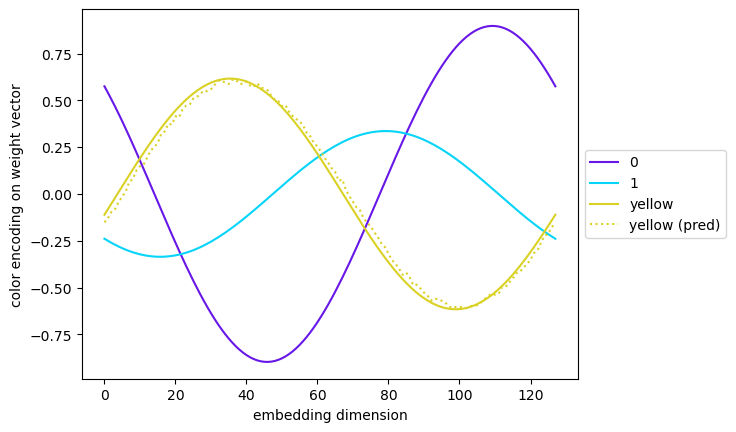

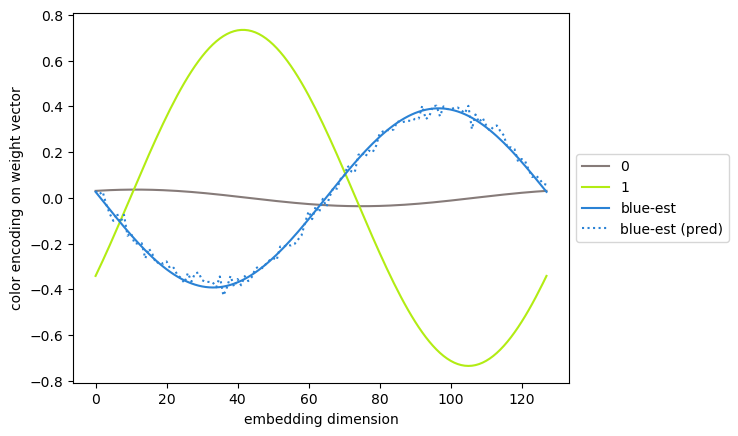

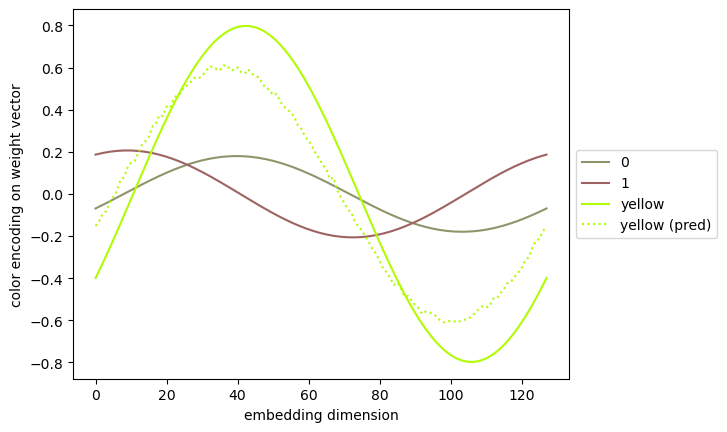

In [184]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(dataset, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.target_embeddings[i], color=dataset.target_rgbs[i], label=dataset.texts[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()


def vis_set(dataset, y_preds, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.all_lab_embeddings[i][0], color=dataset.all_rgb_colors[i][0], label=str(0))
        ax.plot(dataset.all_lab_embeddings[i][1], color=dataset.all_rgb_colors[i][1], label=str(1))
        ax.plot(dataset.all_lab_embeddings[i][2], color=dataset.all_rgb_colors[i][2], label=dataset.texts[i])
        ax.plot(y_preds[i]                      , color=dataset.all_rgb_colors[i][2], label=dataset.texts[i]+ " (pred)", linestyle='dotted')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()


vis_set(far_train_ds,y_pred,range(0,1))
vis_set(far_train_ds,y_pred,range(1,2))
vis_set(far_train_ds,y_pred,range(2,3))
